# Investigating the ABoVE CoVAR stack with AGB predictions

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#### Read in our data

In [2]:
datafile = '/projects/my-public-bucket/sentinel1_seasonal_comps/IS2_AGB_CoVars_training_s1.gpkg'

gdf = gpd.read_file(datafile)

In [16]:
# remove any rows with -9999
gdf = gdf[gdf['blue'] != -9999]
gdf = gdf.dropna(axis=0)

### Investigate the distribution of the independent variable (AGB)

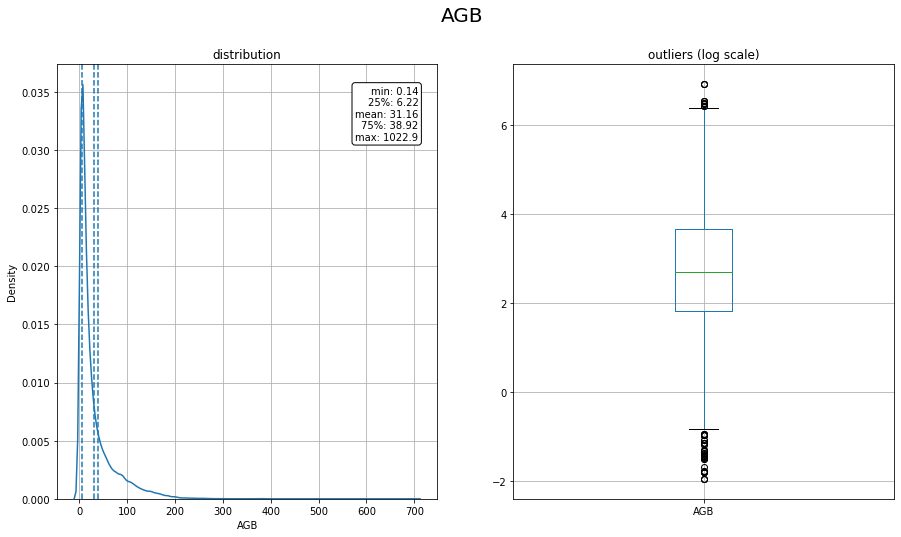

In [17]:
x = "AGB"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8),  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = gdf[x].fillna(gdf[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.kdeplot(variable, ax=ax[0])
des = gdf[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(gdf[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

### Investigate the relationship between AGB and a selected dependent variable

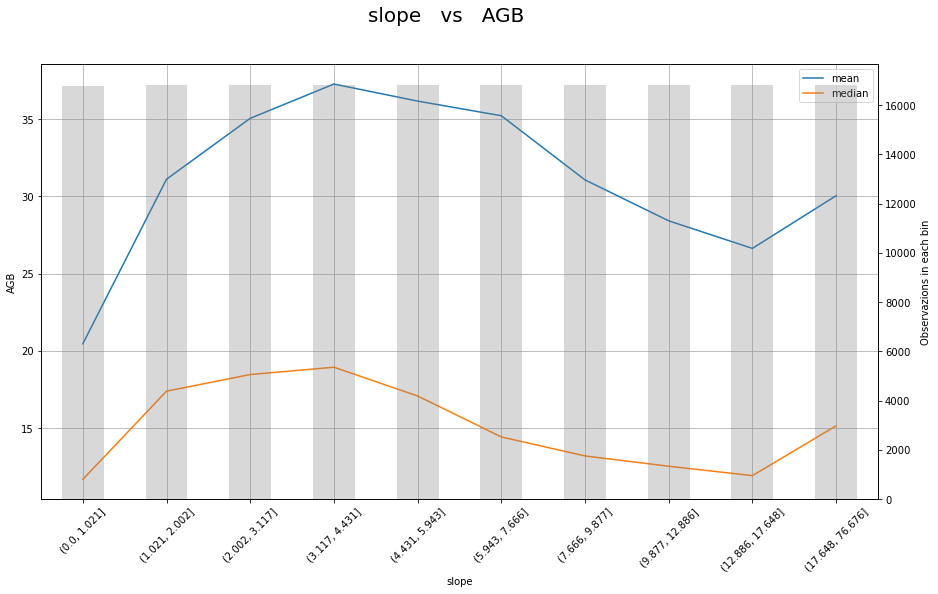

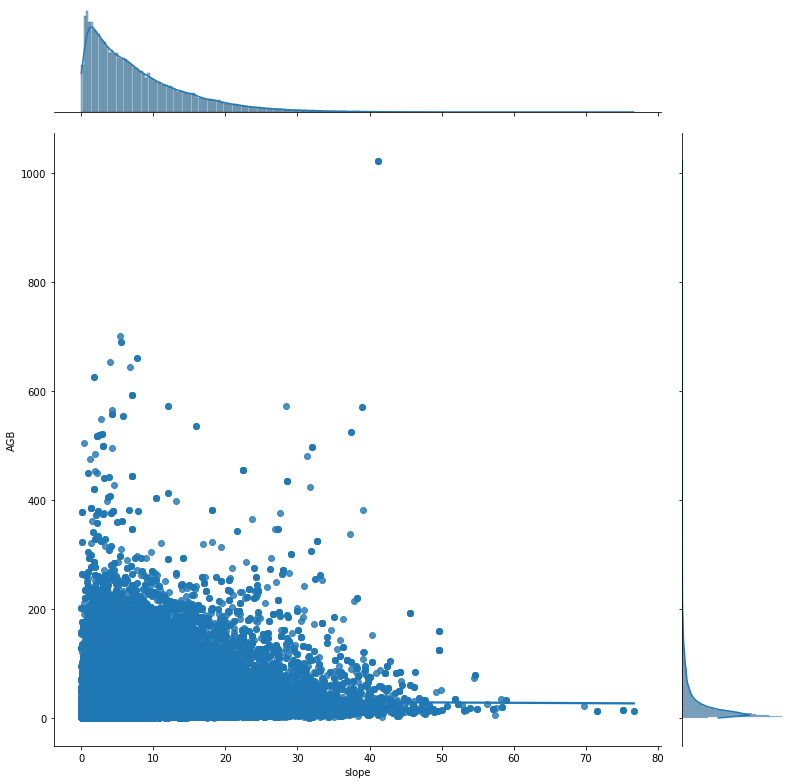

In [6]:
x, y = "slope", "AGB"
### bin plot
dtf_noNan = gdf[gdf[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks, 
           duplicates='drop')])[y].agg(['mean','median','size'])
figsize=[15,8]
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()
### scatter plot
sns.jointplot(x=x, y=y, data=gdf, dropna=True, kind='reg', 
              height=int((figsize[0]+figsize[1])/2) )
plt.show()

In [7]:
print(gdf.keys())

Index(['lon', 'lat', 'AGB', 'SE', 'tile_num', 'tile_num_int', 'elevation',
       'slope', 'tsri', 'tpi', 'slope_mask', 'blue', 'green', 'red', 'nir',
       'swir', 'swir2', 'ndvi', 'savi', 'msavi', 'ndmi', 'evi', 'nbr', 'nbr2',
       'tcb', 'tcg', 'tcw', 'vv_fall', 'vh_fall', 'vv_spring', 'vh_spring',
       'vv_fall_db', 'vh_fall_db', 'vv_spring_db', 'vh_spring_db', 'geometry'],
      dtype='object')


In [18]:
continuous = gdf.drop(columns=['AGB','lat','lon', 'tile_num', 'geometry', 'SE', 'tile_num_int', 'slope_mask'], axis=1)

for c in continuous:
	x, y = c, "AGB"
	dtf_noNan = gdf[gdf[x].notnull()]
	coeff, p = scipy.stats.pearsonr(dtf_noNan[x], dtf_noNan[y])
	coeff, p = round(coeff, 3), round(p, 3)
	conclusion = "Significant" if p < 0.05 else "Non-Significant"
	print(c,":Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

elevation :Pearson Correlation: -0.244 Significant (p-value: 0.0)
slope :Pearson Correlation: -0.011 Significant (p-value: 0.0)
tsri :Pearson Correlation: -0.006 Significant (p-value: 0.013)
tpi :Pearson Correlation: 0.072 Significant (p-value: 0.0)
blue :Pearson Correlation: -0.251 Significant (p-value: 0.0)
green :Pearson Correlation: -0.391 Significant (p-value: 0.0)
red :Pearson Correlation: -0.371 Significant (p-value: 0.0)
nir :Pearson Correlation: -0.149 Significant (p-value: 0.0)
swir :Pearson Correlation: -0.397 Significant (p-value: 0.0)
swir2 :Pearson Correlation: -0.366 Significant (p-value: 0.0)
ndvi :Pearson Correlation: 0.175 Significant (p-value: 0.0)
savi :Pearson Correlation: -0.019 Significant (p-value: 0.0)
msavi :Pearson Correlation: -0.036 Significant (p-value: 0.0)
ndmi :Pearson Correlation: 0.332 Significant (p-value: 0.0)
evi :Pearson Correlation: -0.397 Significant (p-value: 0.0)
nbr :Pearson Correlation: -0.036 Significant (p-value: 0.0)
nbr2 :Pearson Correla

##   Preprocessing
- each observation must be represented by a single row, 
- The dataset must be partitioned into at least two sets: testing and training
- Categorical data must be encoded, which means converting labels into integers because machine learning expects numbers, not strings.
- It’s good practice to scale the data, it helps to normalize the data within a particular range and speed up the calculations in an algorithm.


#### First, drop columns not needed in modeling


In [19]:
dtf = gdf.drop(columns=['lat','lon', 'tile_num', 'geometry', 'SE', 'tile_num_int', 'slope_mask', 'vv_fall', 'vh_fall', 'vv_spring', 'vh_spring'], axis=1)


In [20]:
## split data
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)

## print info
print("X_train shape:", dtf_train.drop("AGB",axis=1).shape, "| X_test shape:", dtf_test.drop("AGB",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["AGB"]),2), "| y_test mean:", round(np.mean(dtf_test["AGB"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("AGB",axis=1).columns.to_list())

X_train shape: (117687, 24) | X_test shape: (50438, 24)
y_train mean: 31.13 | y_test mean: 31.22
25 features: ['elevation', 'slope', 'tsri', 'tpi', 'blue', 'green', 'red', 'nir', 'swir', 'swir2', 'ndvi', 'savi', 'msavi', 'ndmi', 'evi', 'nbr', 'nbr2', 'tcb', 'tcg', 'tcw', 'vv_fall_db', 'vh_fall_db', 'vv_spring_db', 'vh_spring_db']


### For regression problems, it is often desirable to transform both the input and the target variables. This normalizes the different variables to the same scale (0 - 1) rather than the widely varying scales they have. Their distributions remian the same, but they all occur within the same range. I shall use the RobustScaler which transforms the feature by subtracting the median and then dividing by the interquartile range (75% value — 25% value). The advantage of this scaler is that it’s less affected by outliers.

In [21]:
# Train
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X_train = scalerX.fit_transform(dtf_train.drop("AGB", axis=1))
X_test = scalerX.fit_transform(dtf_test.drop("AGB", axis=1))

dtf_scaled_train= pd.DataFrame(X_train, columns=dtf_train.drop("AGB", axis=1).columns, index=dtf_train.index)
dtf_scaled_test= pd.DataFrame(X_test, columns=dtf_test.drop("AGB", axis=1).columns, index=dtf_test.index)


dtf_scaled_train["y_train_scaled"] = scalerY.fit_transform(dtf_train["AGB"].values.reshape(-1,1))
dtf_scaled_test["y_test_scaled"] = scalerY.fit_transform(dtf_test["AGB"].values.reshape(-1,1))


## Feature Selection

### I already did a first “manual” feature selection during data analysis by excluding irrelevant columns. Now it’s going to be a bit different because we have to deal with the multicollinearity problem, which refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related.Let’s compute the correlation matrix to see it:

Text(0.5, 1.0, 'pearson correlation')

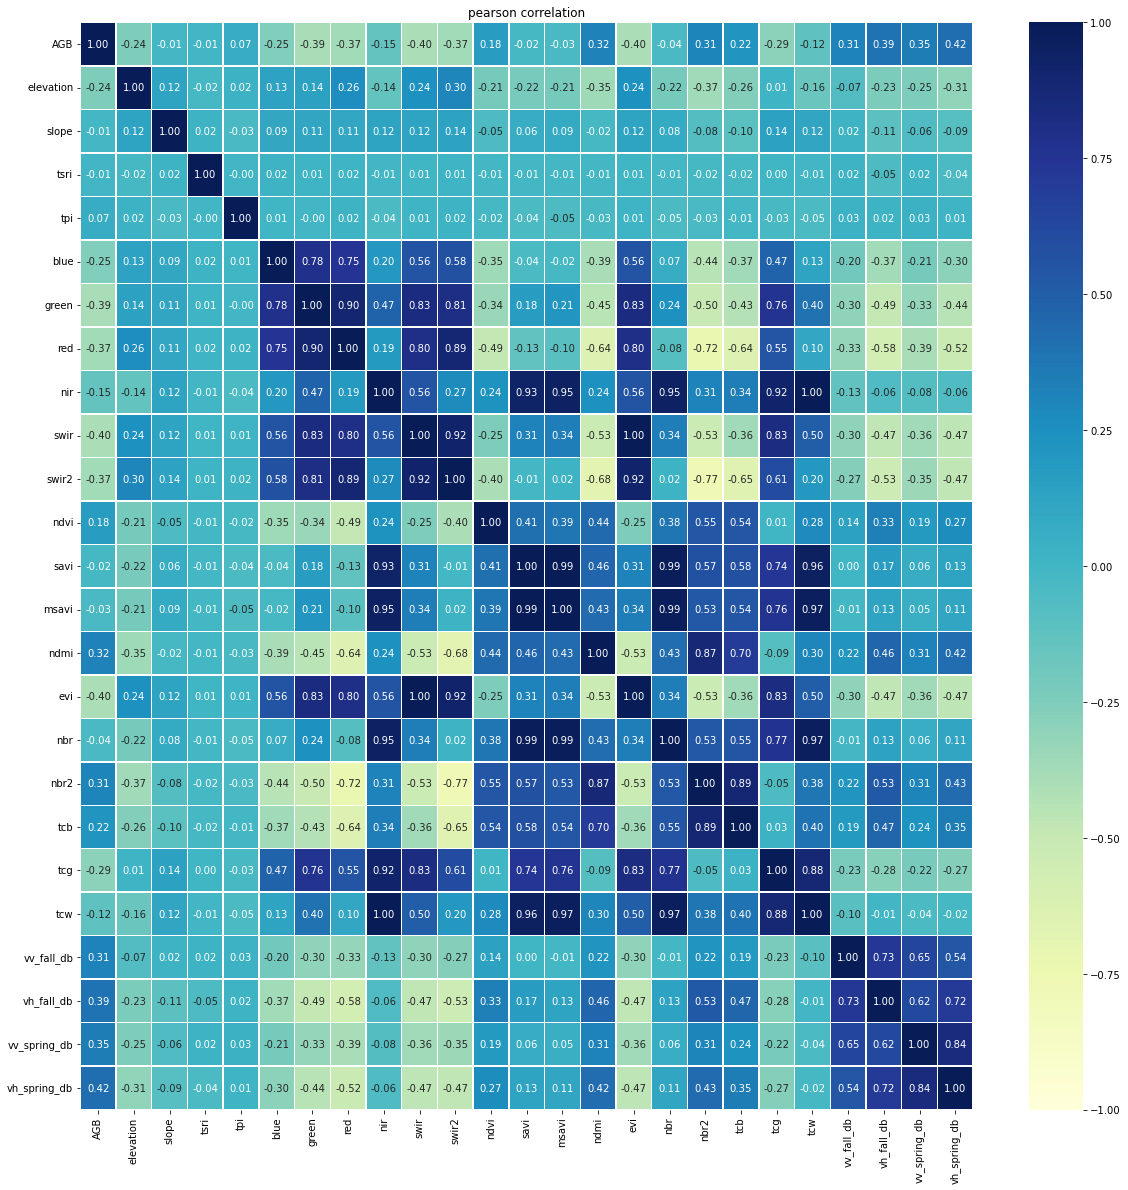

In [22]:
plt.figure(figsize=(20,20))
corr_matrix = dtf_train.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

# ML FEATURE SELECTION
### Alternatively, you can use ensemble methods to get feature importance. Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone. I will give an example using a random forest model.

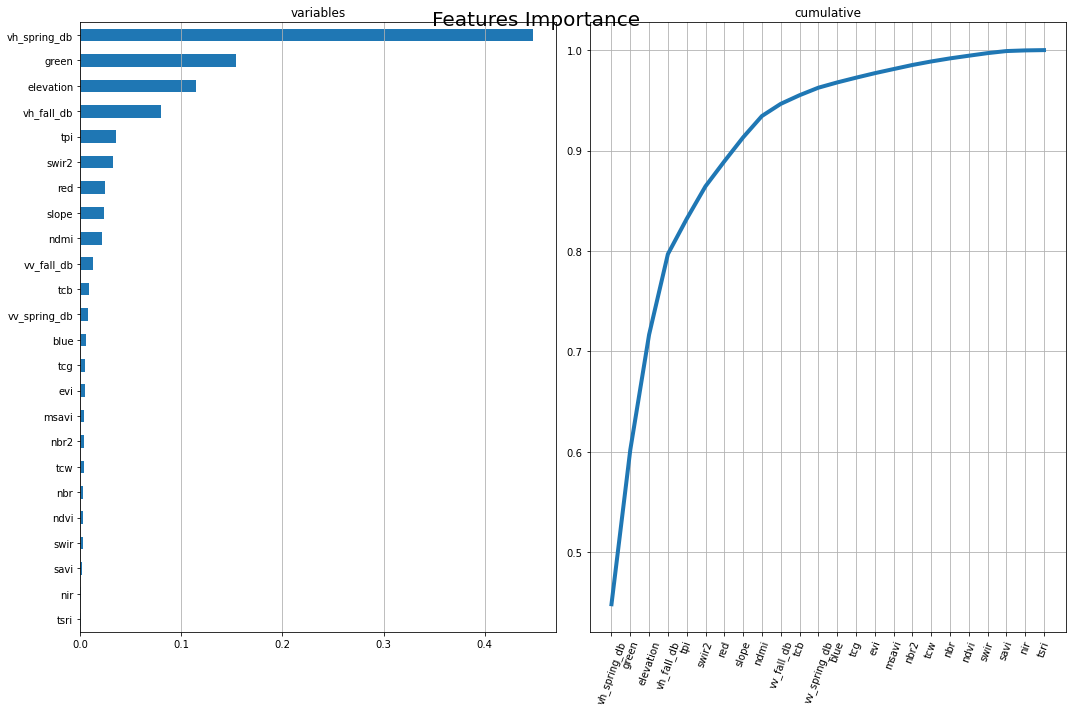

In [23]:
X = dtf_scaled_train.drop("y_train_scaled", axis=1).values
y = dtf_scaled_train["y_train_scaled"].values
feature_names = dtf_scaled_train.drop("y_train_scaled", axis=1).columns.tolist()
## call model
model = ensemble.GradientBoostingRegressor()
## Importance
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.tight_layout()
plt.show()